In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Imports & EDA

In [102]:
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train_test_data = pd.concat([train, test],axis=0)
train_test_data.head(1463)
train_test_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


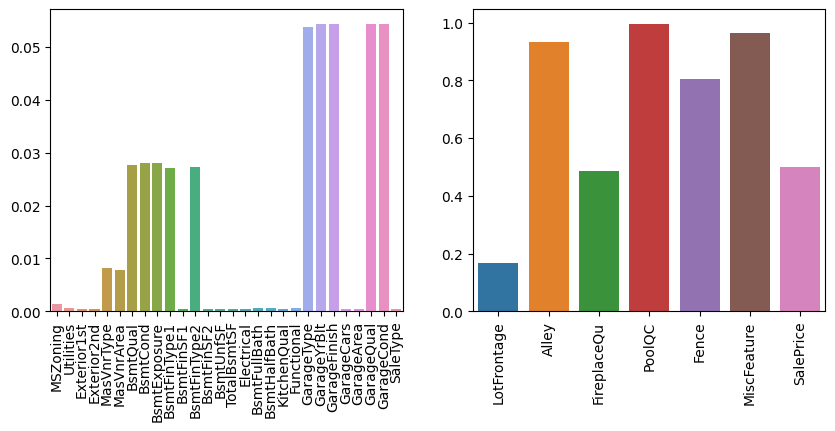

In [103]:
# Missing ratio of each feature
missing_ratio = train_test_data.isnull().sum() / len(train_test_data)
missing_ratio = missing_ratio[missing_ratio.values>0]
missing_ratio_low = missing_ratio[missing_ratio.values<=0.1]
missing_ratio_high = missing_ratio[missing_ratio.values>0.1]

fig = plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
sns.barplot(x=missing_ratio_low.index,y=missing_ratio_low.values)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.barplot(x=missing_ratio_high.index,y=missing_ratio_high.values)
plt.xticks(rotation=90);

In [104]:
# High missing ratio features
missing_ratio_high.index

# Filling in LotFrontage
train_test_data['LotFrontage']=train_test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))

# Filling in MiscFeature
train_test_data['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Other',inplace=True)
train_test_data['MiscFeature'].fillna(value='Other',inplace=True)

# Drop some features with high missing ratio
train_test_data.drop(['Alley','FireplaceQu','PoolQC','Fence','SalePrice'],axis=1,inplace=True)

In [110]:
# Low missing ratio features
missing_ratio_low.index

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

In [112]:
train_test_data[train_test_data['GarageCond'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
39,40,90,RL,65.0,6040,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,6,2008,WD,AdjLand
48,49,190,RM,33.0,4456,Pave,Reg,Lvl,AllPub,Inside,...,102,0,0,0,Other,0,6,2009,New,Partial
78,79,90,RL,72.0,10778,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,4,2010,WD,Normal
88,89,50,C (all),105.0,8470,Pave,IR1,Lvl,AllPub,Corner,...,156,0,0,0,Other,0,10,2009,ConLD,Abnorml
89,90,20,RL,60.0,8070,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,8,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2894,50,C (all),60.0,8520,Grvl,Reg,Bnk,AllPub,Inside,...,0,0,0,0,Other,0,4,2006,WD,Normal
1449,2910,180,RM,21.0,1470,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,4,2006,WD,Normal
1453,2914,160,RM,21.0,1526,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,6,2006,WD,Normal
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,Other,0,6,2006,WD,Normal
